# Tool comparison

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.transforms as transforms
import glob
import matplotlib.patches as patches

In [2]:
# path where figures are going to be saved
FIG_PATH = 'plots'

------

# Read results of individual analysis

In [3]:
result_files = glob.glob("results/*")
result_files = [f for f in result_files if "merged_results.tsv" not in f and not os.path.isdir(f)]

In [4]:
rows = []
for f in result_files:
    
    base = os.path.splitext(os.path.basename(f))[0]
    elements = base.split("_")
    element_names = ["dataset", "tool", "replicates", "transform", "conditions", "subset"]
    
    if elements[2] not in ["norep", "rep"]:
        continue
    
    info = {}
    for i, element in enumerate(elements):
        info[element_names[i]] = element
        
    
    # Add p-value/props
    results = pd.read_csv(f, sep="\t")

    #Get max of covariates if sccoda
    if "sccoda" in base:
        results = results.groupby(["Cell Type", "fdr"])["credible_effect"].max().to_frame().reset_index()
    
    for i, row in results.iterrows():
        info_row = info.copy()
        
        if "sccoda" in base:

            info_row["cluster"] = row.iloc[0]
            
            info_row["FDR"] = row["fdr"]
            info_row["credible_effect"] = row["credible_effect"]
            info_row["plot_value"] = int(info_row["credible_effect"])
            info_row["significant"] = info_row["credible_effect"]  # bool
            
        else:
            info_row["cluster"] = row.iloc[0]
            info_row["baseline_props"] = row.iloc[1] if "scanpro" in base else row.iloc[2]
            info_row["p-value"] = row.iloc[-2]
            info_row["p-value_adjusted"] = row.iloc[-1]
            info_row["significant"] = info_row["p-value_adjusted"] < 0.05

            info_row["plot_value"] = -np.log10(info_row["p-value_adjusted"])
            if info_row["plot_value"] == np.inf:
                info_row["plot_value"] = 20

        rows.append(info_row)

In [5]:
results = pd.DataFrame(rows)

In [6]:
results

,dataset,tool,replicates,transform,cluster,baseline_props,p-value,p-value_adjusted,significant,plot_value,conditions,subset,FDR,credible_effect
0,pbmc,propeller,rep,arcsin,NK cells,0.146479,0.028605,0.143026,False,0.844586,NaN,NaN,NaN,NaN
1,pbmc,propeller,rep,arcsin,T cells,0.566610,0.137299,0.343247,False,0.464393,NaN,NaN,NaN,NaN
2,pbmc,propeller,rep,arcsin,Dendritic cells,0.017112,0.280882,0.468137,False,0.329627,NaN,NaN,NaN,NaN
3,pbmc,propeller,rep,arcsin,B cells,0.098383,0.699920,0.874900,False,0.058042,NaN,NaN,NaN,NaN
4,pbmc,propeller,rep,arcsin,Monocytes,0.171416,0.929444,0.929444,False,0.031777,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,pbmc,scanpro,rep,arcsin,B cells,0.098383,0.699921,0.874901,False,0.058041,NaN,NaN,NaN,NaN
747,pbmc,scanpro,rep,arcsin,Dendritic cells,0.017112,0.280882,0.468136,False,0.329628,NaN,NaN,NaN,NaN
748,pbmc,scanpro,rep,arcsin,Monocytes,0.171416,0.929443,0.929443,False,0.031777,NaN,NaN,NaN,NaN
749,pbmc,scanpro,rep,arcsin,NK cells,0.146479,0.028605,0.143026,False,0.844585,NaN,NaN,NaN,NaN


In [7]:
results.to_csv("results/merged_results.tsv", sep="\t")

In [8]:
results["dataset"].unique()

array(['pbmc', 'scatac', 'heart', 'humanMI', 'covid'], dtype=object)

----------------------

# Plot FDR overview for scCODA

In [9]:
results_sccoda = results[results["tool"] == "sccoda"]

In [10]:
plot_title = {"pbmc": "PBMC data", 
              "heart": "Heart development data", 
              "covid": "COVID-19 data"}

In [11]:
selected_FDR = {"pbmc": 0.3, 
                "heart": 0.2,
                "covid": 0.2}

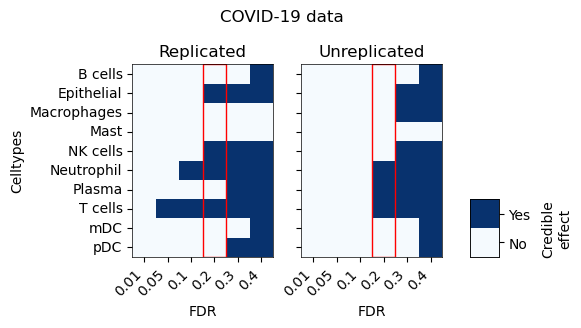

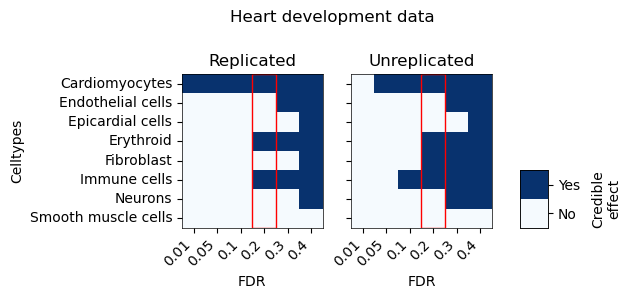

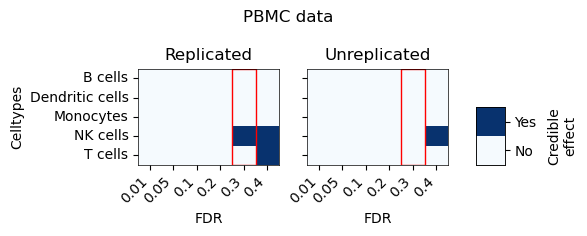

In [12]:
colors = sns.color_palette("Blues", n_colors=100).as_hex()
colors = [colors[0], colors[-1]]
    
for dataset, table in results_sccoda.groupby("dataset"):
    
    # Prepare data
    rep_pivot = table[table["replicates"] == "rep"].pivot(index="cluster", columns="FDR", values="significant")
    norep_pivot = table[table["replicates"] == "norep"].pivot(index="cluster", columns="FDR", values="significant")

    n_clusters = len(rep_pivot)

    # Prepare plot
    fig, axarr = plt.subplots(ncols=2, figsize=(4, n_clusters/4))
    sig_cax = inset_axes(axarr[1],
                         width="20%", height=f"{3/n_clusters*100}%",
                         loc='lower left',
                         bbox_to_anchor=(1.2, 0, 1, 1),
                         bbox_transform=axarr[1].transAxes, borderpad=0)
    fig.suptitle(plot_title[dataset], y=1.1 + (10-n_clusters)/20)
    
    ### Plot data
    sns.heatmap(rep_pivot, cmap=colors, ax=axarr[0], cbar=False)
    axarr[0].set_title("Replicated")
    
    sns.heatmap(norep_pivot, cmap=colors, ax=axarr[1], 
                cbar_ax=sig_cax,
                cbar_kws={"label": "Credible effect"})
    axarr[1].set_title("Unreplicated")
    
    # Format labels
    axarr[0].set_ylabel("Celltypes")
    axarr[1].set_ylabel("")
    axarr[1].set_yticklabels([])
    
    for ax in axarr:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
        
        fdr_idx = rep_pivot.columns.tolist().index(selected_FDR[dataset])
        ax.add_patch(
             patches.Rectangle((fdr_idx, 0),
                 1, 
                 n_clusters,
                 edgecolor='red',
                 fill=False,
                 lw=1))
    
    # Drawing borders
    for ax in list(axarr) + [sig_cax]:
        for _, spine in ax.spines.items():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
            
    #scCoda cmap to categorical
    colorbar = axarr[1].collections[0].colorbar
    colorbar.set_label("Credible\neffect", labelpad=8)
    colorbar.set_ticks([0.25,0.75])
    colorbar.set_ticklabels(["No", "Yes"])
    
    plt.savefig(f"{FIG_PATH}/{dataset}_sccoda_fdr.pdf", bbox_inches="tight")
    plt.show()

----------

# Compare results per dataset

In [13]:
datasets = ["pbmc", "heart", "covid"]

In [14]:
results_compare = results.copy()
results_compare = results_compare[results_compare["dataset"].isin(datasets)]
results_compare["tool_rep_transform"] = results_compare["tool"] + "_" + results_compare["replicates"] + "_" + results_compare["transform"].fillna("")

In [15]:
#select sccoda based on FDR
results_compare["chosen_FDR"] = [selected_FDR.get(dataset, None) for dataset in results_compare["dataset"]]
results_compare = results_compare[~((results_compare["tool"] == "sccoda") & (results_compare["FDR"] != results_compare["chosen_FDR"]))] 
results_compare.drop(columns="chosen_FDR", inplace=True)

In [16]:
results_compare

,dataset,tool,replicates,transform,cluster,baseline_props,p-value,p-value_adjusted,significant,plot_value,conditions,subset,FDR,credible_effect,tool_rep_transform
0,pbmc,propeller,rep,arcsin,NK cells,0.146479,0.028605,0.143026,False,0.844586,NaN,NaN,NaN,NaN,propeller_rep_arcsin
1,pbmc,propeller,rep,arcsin,T cells,0.566610,0.137299,0.343247,False,0.464393,NaN,NaN,NaN,NaN,propeller_rep_arcsin
2,pbmc,propeller,rep,arcsin,Dendritic cells,0.017112,0.280882,0.468137,False,0.329627,NaN,NaN,NaN,NaN,propeller_rep_arcsin
3,pbmc,propeller,rep,arcsin,B cells,0.098383,0.699920,0.874900,False,0.058042,NaN,NaN,NaN,NaN,propeller_rep_arcsin
4,pbmc,propeller,rep,arcsin,Monocytes,0.171416,0.929444,0.929444,False,0.031777,NaN,NaN,NaN,NaN,propeller_rep_arcsin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,pbmc,scanpro,rep,arcsin,B cells,0.098383,0.699921,0.874901,False,0.058041,NaN,NaN,NaN,NaN,scanpro_rep_arcsin
747,pbmc,scanpro,rep,arcsin,Dendritic cells,0.017112,0.280882,0.468136,False,0.329628,NaN,NaN,NaN,NaN,scanpro_rep_arcsin
748,pbmc,scanpro,rep,arcsin,Monocytes,0.171416,0.929443,0.929443,False,0.031777,NaN,NaN,NaN,NaN,scanpro_rep_arcsin
749,pbmc,scanpro,rep,arcsin,NK cells,0.146479,0.028605,0.143026,False,0.844585,NaN,NaN,NaN,NaN,scanpro_rep_arcsin


In [17]:
plot_title = {"pbmc": "PBMC male vs. female", 
              "heart": "Heart development", 
              "covid": "COVID-19 severity"}

In [18]:
value_table = results_compare.pivot(columns="tool_rep_transform", index=["dataset", "cluster"], values="plot_value")
value_table["propeller_norep"] = np.nan

In [19]:
value_table

tool_rep_transform           propeller_rep_arcsin  propeller_rep_logit  \
dataset cluster                                                          
covid   B cells                          0.873450             0.776313   
        Epithelial                       0.083308             0.623910   
        Macrophages                      0.381487             0.604167   
        Mast                             0.020118             0.290126   
        NK cells                         1.552683             1.456743   
        Neutrophil                       1.552683             5.450204   
        Plasma                           0.381487             1.987865   
        T cells                          1.262288             0.888150   
        mDC                              1.262288             0.776313   
        pDC                              1.552683             1.456743   
heart   Cardiomyocytes                   1.174507             3.512313   
        Endothelial cells                0.278134             0.147701   
        Epicardial cells                 0.278134             0.270177   
        Erythroid                        3.043311            19.331558   
        Fibroblast                       1.012994             1.710098   
        Immune cells                     1.349256             4.424939   
        Neurons                          0.547356             0.455680   
        Smooth muscle cells              0.035357             0.147701   
pbmc    B cells                          0.058042             0.089344   
        Dendritic cells                  0.329627             0.307783   
        Monocytes                        0.031777             0.022571   
        NK cells                         0.844586             1.307851   
        T cells                          0.464393             0.423156   

tool_rep_transform           scanpro_norep_arcsin  scanpro_norep_logit  \
dataset cluster                                                          
covid   B cells                          0.902234             0.796544   
        Epithelial                       0.819213             0.495483   
        Macrophages                      2.875428             1.486671   
        Mast                             0.181482             0.310593   
        NK cells                         2.248264             1.881070   
        Neutrophil                       4.740443             5.272604   
        Plasma                           3.593829             3.736511   
        T cells                          3.852174             2.067633   
        mDC                              0.690854             0.525687   
        pDC                              1.298066             1.330040   
heart   Cardiomyocytes                   4.393568             2.512814   
        Endothelial cells                0.613956             0.458683   
        Epicardial cells                 0.894734             0.636320   
        Erythroid                        1.570762             2.485801   
        Fibroblast                       2.555563             1.563729   
        Immune cells                     3.123885             2.011005   
        Neurons                          0.475621             0.292753   
        Smooth muscle cells              0.199325             0.148236   
pbmc    B cells                          0.288661             0.317793   
        Dendritic cells                  0.299925             0.407756   
        Monocytes                        0.276104             0.306108   
        NK cells                         1.542786             1.149497   
        T cells                          1.284639             0.979621   

tool_rep_transform           scanpro_rep_arcsin  scanpro_rep_logit  \
dataset cluster                                                      
covid   B cells                        0.900937           0.832062   
        Epithelial                     0.085667           0.552644   
        Macrophage

In [20]:
annot_table = results_compare.pivot(columns="tool_rep_transform", index=["dataset", "cluster"], values="significant")
annot_table.replace({True: "*", False: ""}, inplace=True)
annot_table["propeller_norep"] = "NA"

In [21]:
def join_xticks(fig, ax, label):
    """ Add horizontal bar to join x axis labels in heatmap """
    
    ticks = ax.xaxis.get_major_ticks()
    ticks = [tick for tick in ticks if tick.label1._text == label]
    
    # Convert from display -> converted coordinates
    trans_y = ax.transData
    trans_y_inv = trans_y.inverted()                                      
    tick_bboxes = [tick.tick1line.get_window_extent().transformed(trans_y_inv) for tick in ticks] 
    bbox_trans = tick_bboxes[0]
    
    #Plot horizontal line between ticks
    trans = transforms.blended_transform_factory(ax.transData, trans_y)
    tick_x = [tick._loc for tick in ticks]  # data coordinates
    tick_y = [bbox_trans.y0 + (bbox_trans.y0-bbox_trans.y1)/2]*2  #converted coordinates + half length
    ax.plot(tick_x, tick_y, color="black", lw=0.8, transform=trans, clip_on=False)

    # Move labels using transform
    dx = 0.1
    offset = transforms.ScaledTranslation(dx, 0, fig.dpi_scale_trans)
    ticks[0].label1.set_transform(ticks[0].label1.get_transform() + offset)
    _ = [tick.label1.set_visible(False) for tick in ticks[1:]]

/home/yalayou/.conda/envs/scanpro_analysis/lib/python3.9/site-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/yalayou/.conda/envs/scanpro_analysis/lib/python3.9/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
/home/yalayou/.conda/envs/scanpro_analysis/lib/python3.9/site-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/yalayou/.conda/envs/scanpro_analysis/lib/python3.9/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
/home/yalayou/.conda/envs/scanpro_analysis/lib/python3.9/site-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/yalayou/.conda/envs/scanpro_analysis/lib/python3.9/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


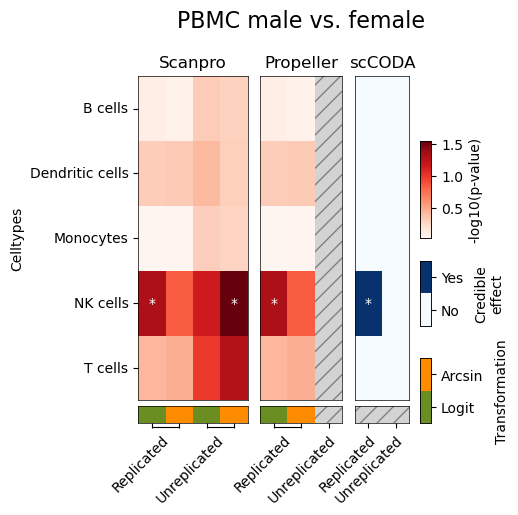

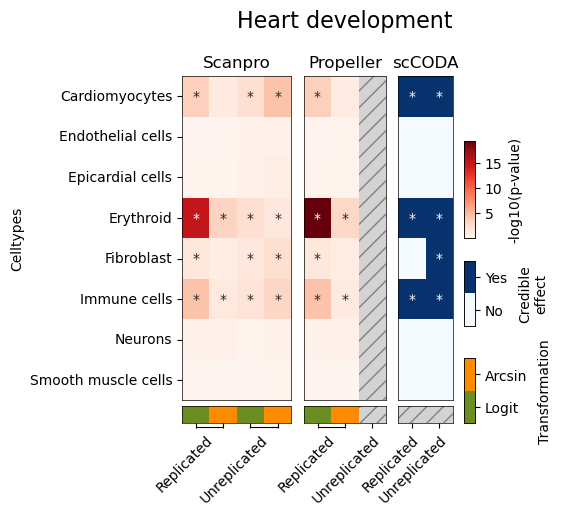

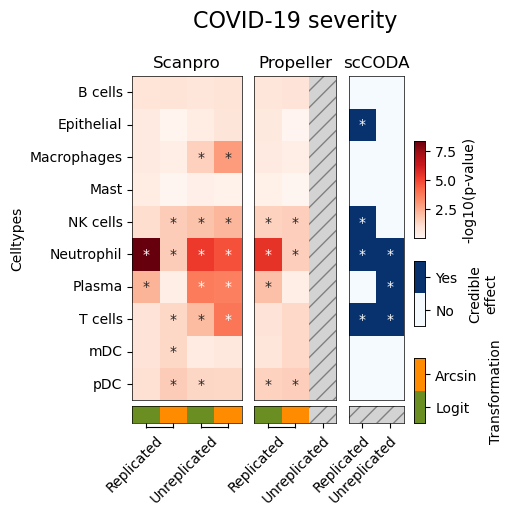

In [22]:
for dataset in datasets:
    
    # Get data
    values = value_table.query(f"dataset == '{dataset}'").reset_index(level=0, drop=True)
    annot = annot_table.query(f"dataset == '{dataset}'").reset_index(level=0, drop=True)
    n_rows = len(values)
    
    # Initialize plotting grid
    fig, axarr = plt.subplots(2,3, figsize=(3.5, 4.5), gridspec_kw={'width_ratios': [4,3,2], 
                                                                    'height_ratios': [0.95,0.05]})
    axarr = axarr.flatten()
    plt.subplots_adjust(wspace=0.15, hspace=0.03)
    
    ############### Colorbars ################

    #Create extra axes for colorbars
    transform_colors = ["olivedrab", "darkorange"]
    ax = axarr[2]
    transform_cax = inset_axes(ax,
                               width="20%", height="20%",
                               loc='lower left',
                               bbox_to_anchor=(1.2, -0.07, 1, 1),
                               bbox_transform=ax.transAxes, borderpad=0)
    transform_cax.set_frame_on(True)
    
    pvalue_cax = inset_axes(ax,
                            width="20%", height="30%",
                            loc='lower left',
                            bbox_to_anchor=(1.2, 0.5, 1, 1),
                            bbox_transform=ax.transAxes, borderpad=0)
    pvalue_cax.set_frame_on(True)
    
    percent_cax = inset_axes(ax,
                             width="20%", height="20%",
                             loc='lower left',
                             bbox_to_anchor=(1.2, 0.23, 1, 1),
                             bbox_transform=ax.transAxes, borderpad=0)
    percent_cax.set_frame_on(True)

    #Get max p-value to set for scanpro/propeller
    max_value = values.max().max()  
    
    ########## Scanpro ##########
    columns = ["scanpro_rep_logit", "scanpro_rep_arcsin", "scanpro_norep_logit", "scanpro_norep_arcsin"]
    
    # First row
    ax = axarr[0]
    sns.heatmap(values[columns], 
                annot=annot[columns], fmt='',
                ax=ax, cmap='Reds', vmax=max_value, cbar_ax=pvalue_cax, xticklabels=False, 
                cbar_kws={"label": "-log10(p-value)"})

    # Second row
    ax = axarr[3]
    sns.heatmap([[0,1,0,1]], ax=ax, cbar_ax=transform_cax, 
                yticklabels=False, 
                cmap=transform_colors)

    #Transformation to categorical
    colorbar = axarr[3].collections[0].colorbar
    colorbar.set_label("Transformation", labelpad=8)
    colorbar.set_ticks([0.25,0.75])
    colorbar.set_ticklabels(["Logit", "Arcsin"])
    
    #xticks
    ax.set_xticks(ax.get_xticks(), ["Replicated",  "Replicated", "Unreplicated", "Unreplicated"], 
                  rotation=45, ha='right', rotation_mode='anchor')
    join_xticks(fig, ax, "Replicated")
    join_xticks(fig, ax, "Unreplicated")

    ########## Propeller ##########
    columns = ["propeller_rep_logit", "propeller_rep_arcsin", "propeller_norep"]

    # First row
    ax = axarr[1]
    g = sns.heatmap(values[columns],
                    annot=annot[columns], fmt='',
                    ax=ax, yticklabels=False, xticklabels=False,
                    cmap='Reds', cbar=False, vmax=max_value)    
    
    # Second row
    ax = axarr[4]
    sns.heatmap([[0,1,np.nan]], ax=ax, cbar=False, xticklabels=True, yticklabels=False, cmap=transform_colors)

    # xticks
    ax.set_xticks(ax.get_xticks(), ["Replicated",  "Replicated", "Unreplicated"], rotation=45, ha='right', rotation_mode='anchor')
    join_xticks(fig, ax, "Replicated")
    
    ########## Sccoda ##########
    columns = ["sccoda_rep_", "sccoda_norep_"]
    
    # First row
    ax = axarr[2]
    colors = sns.color_palette("Blues", n_colors=100).as_hex()
    colors = [colors[0], colors[-1]]

    sns.heatmap(values[columns], 
                annot=annot[columns], fmt='',
                cmap=colors,
                ax=ax, yticklabels=False, xticklabels=False,
                cbar_ax=percent_cax,
                cbar_kws={"label": "Credible effect"})
    
    # Second row
    ax = axarr[5]
    #ax.axis("off")
    sns.heatmap([[np.nan, np.nan]], ax=ax, cbar=False, xticklabels=True, yticklabels=False) # no transformation
    
    #Ticks
    ax.set_xticks(ax.get_xticks(), ["Replicated",  "Unreplicated"], rotation=45, ha='right', rotation_mode='anchor')
    
    #scCoda cmap to categorical
    colorbar = axarr[2].collections[0].colorbar
    colorbar.set_label("Credible\neffect", labelpad=8)
    colorbar.set_ticks([0.25,0.75])
    colorbar.set_ticklabels(["No", "Yes"])
    
    
    ############ Final adjustments ##############
    
    #Titles
    axarr[0].set_title("Scanpro")
    axarr[1].set_title("Propeller")
    axarr[2].set_title("scCODA")
    
    ### Set format of labels
    for ax in axarr:
        ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), rotation=0, ha='right', rotation_mode='anchor')
        ax.set_ylabel("")
        ax.set_xlabel("")
        
        # Drawing the frame
        for _, spine in ax.spines.items():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
    
    _ = axarr[0].set_ylabel("Celltypes")
    
    #Border around cbars
    for cax in [pvalue_cax, percent_cax, transform_cax]:
        for _, spine in cax.spines.items():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
            
    # Background for NAs
    for ax in axarr:
        ax.patch.set_facecolor('lightgrey')
        ax.patch.set_edgecolor('grey')
        ax.patch.set_hatch('//')
    
    # Set title of plot
    title = plot_title.get(dataset, dataset)
    axarr[1].text(0.5, 1.15, title, transform=axarr[1].transAxes, fontsize=16, ha="center")
    
    # Save final figure
    plt.savefig(f"{FIG_PATH}/{dataset}_tool_comparison.pdf", bbox_inches="tight")

-------------